# Apriori Algorithm Implementation Assignment

### Objective:
You will implement the **Apriori algorithm** from scratch (i.e., without using any libraries like `mlxtend`) to find frequent itemsets and generate association rules.

### Dataset:
Use the [Online Retail Dataset](https://www.kaggle.com/datasets/vijayuv/onlineretail) from Kaggle. You can filter it for a specific country (e.g., `United Kingdom`) and time range to reduce size if needed.

---

## Step 1: Data Preprocessing

- Load the dataset
- Remove rows with missing values
- Filter out rows where `Quantity <= 0`
- Convert Data into Basket Format

👉 **Implement code below**

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

# ======================
# 1. Load and Preprocess
# ======================

# Load dataset (adjust path as needed)
df = pd.read_csv("OnlineRetail.csv", encoding="ISO-8859-1")

# Filter by United Kingdom
df = df[df['Country'] == 'United Kingdom']

# Optional: filter by date range to reduce size
# df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# df = df[df['InvoiceDate'] >= "2010-12-01"]

# Remove missing values
df.dropna(inplace=True)

# Keep only positive quantities
df = df[df['Quantity'] > 0]

# ======================
# 2. Convert to Basket Format
# ======================
basket = (
    df.groupby(['InvoiceNo', 'Description'])['Quantity']
    .sum().unstack().reset_index()
    .fillna(0).set_index('InvoiceNo')
)

# Convert quantities to 1 (presence) or 0 (absence)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Convert basket to list of transactions (sets of items)
transactions = [
    set(row[row > 0].index.astype(str))
    for _, row in basket.iterrows()
]

C:\Users\KRISH\AppData\Local\Temp\ipykernel_20912\1087039147.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


## Step 2: Implement Apriori Algorithm
Step-by-Step Procedure:
1. Generate Frequent 1-Itemsets
Count the frequency (support) of each individual item in the dataset.
Keep only those with support ≥ min_support.
→ Result is L1 (frequent 1-itemsets)
2. Iterative Candidate Generation (k = 2 to n)
While L(k-1) is not empty:
a. Candidate Generation

Generate candidate itemsets Ck of size k from L(k-1) using the Apriori property:
Any (k-itemset) is only frequent if all of its (k−1)-subsets are frequent.
b. Prune Candidates
Eliminate candidates that have any (k−1)-subset not in L(k-1).
c. Count Support
For each transaction, count how many times each candidate in Ck appears.
d. Generate Frequent Itemsets
Form Lk by keeping candidates from Ck that meet the min_support.
Repeat until Lk becomes empty.
Implement the following functions:
1. `get_frequent_itemsets(transactions, min_support)` - Returns frequent itemsets and their support
2. `generate_candidates(prev_frequent_itemsets, k)` - Generates candidate itemsets of length `k`
3. `calculate_support(transactions, candidates)` - Calculates the support count for each candidate

**Write reusable functions** for each part of the algorithm.

In [19]:
# ======================
# 3. Apriori Functions
# ======================
def calculate_support(transactions, candidates):
    """Count support for each candidate itemset."""
    support_counts = {}
    for candidate in candidates:
        count = sum(1 for transaction in transactions if candidate.issubset(transaction))
        if count > 0:
            support_counts[candidate] = count
    return support_counts

def generate_candidates(prev_frequent_itemsets, k):
    """Generate candidate k-itemsets from (k-1)-itemsets."""
    candidates = set()
    prev_items = list(prev_frequent_itemsets)
    for i in range(len(prev_items)):
        for j in range(i + 1, len(prev_items)):
            union_set = prev_items[i].union(prev_items[j])
            if len(union_set) == k:
                candidates.add(union_set)
    return candidates

def get_frequent_itemsets(transactions, min_support):
    """Run the Apriori algorithm."""
    transaction_count = len(transactions)
    min_support_count = min_support * transaction_count
    
    # Step 1: Single-item frequent itemsets
    single_items = {frozenset([item]) for transaction in transactions for item in transaction}
    current_frequent_itemsets = calculate_support(transactions, single_items)
    current_frequent_itemsets = {itemset: count for itemset, count in current_frequent_itemsets.items() if count >= min_support_count}
    
    all_frequent_itemsets = dict(current_frequent_itemsets)
    k = 2
    
    # Step 2: Iteratively find k-itemsets
    while current_frequent_itemsets:
        candidates = generate_candidates(current_frequent_itemsets.keys(), k)
        candidate_counts = calculate_support(transactions, candidates)
        current_frequent_itemsets = {itemset: count for itemset, count in candidate_counts.items() if count >= min_support_count}
        all_frequent_itemsets.update(current_frequent_itemsets)
        k += 1
    return all_frequent_itemsets

## Step 3: Generate Association Rules

- Use frequent itemsets to generate association rules
- For each rule `A => B`, calculate:
  - **Support**
  - **Confidence**
- Only return rules that meet a minimum confidence threshold (e.g., 0.5)

👉 **Implement rule generation function below**

In [22]:
from itertools import combinations

def generate_rules(frequent_itemsets, transactions, min_confidence):
    """
    frequent_itemsets: dict {frozenset: support_count}
    transactions: list of sets
    min_confidence: float (0–1)
    """
    rules = []
    n_transactions = len(transactions)

    for itemset, support_count in frequent_itemsets.items():
        if len(itemset) < 2:
            continue  # Need at least 2 items to form a rule

        # Generate all possible A,B splits
        for i in range(1, len(itemset)):
            for A in combinations(itemset, i):
                A = frozenset(A)
                B = itemset - A

                # Support values
                support_A = sum(1 for t in transactions if A.issubset(t)) / n_transactions
                support_AB = support_count / n_transactions

                # Confidence = support(A∪B) / support(A)
                confidence = support_AB / support_A if support_A > 0 else 0

                if confidence >= min_confidence:
                    rules.append({
                        'A': set(A),
                        'B': set(B),
                        'support': round(support_AB, 3),
                        'confidence': round(confidence, 3)
                    })

    return rules


## Step 4: Output and Visualize

- Print top 10 frequent itemsets
- Print top 10 association rules (by confidence or lift)

👉 **Output results below**

Top Frequent Itemsets:
                           itemset  support_count
WHITE HANGING HEART T-LIGHT HOLDER           1884
           JUMBO BAG RED RETROSPOT           1447
          REGENCY CAKESTAND 3 TIER           1410
     ASSORTED COLOUR BIRD ORNAMENT           1300
                     PARTY BUNTING           1291
           LUNCH BAG RED RETROSPOT           1120
 SET OF 3 CAKE TINS PANTRY DESIGN            1007
           LUNCH BAG  BLACK SKULL.            996
   PAPER CHAIN KIT 50'S CHRISTMAS             945
   NATURAL SLATE HEART CHALKBOARD             938

No association rules generated with the given thresholds.


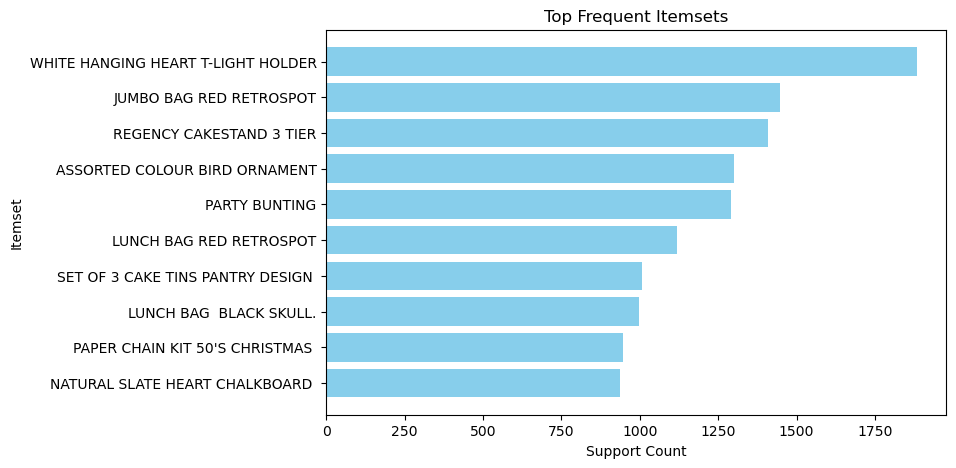


No rules to visualize for metric 'confidence'.


In [25]:
 #5. Output Functions
import matplotlib.pyplot as plt
from itertools import combinations

def print_top_frequent_itemsets(frequent_itemsets, top_n=10):
    df_freq = pd.DataFrame([
        {'itemset': ', '.join(items), 'support_count': count}
        for items, count in frequent_itemsets.items()
    ])
    df_freq = df_freq.sort_values(by='support_count', ascending=False).head(top_n)
    print("Top Frequent Itemsets:")
    print(df_freq.to_string(index=False))
    return df_freq

def print_top_rules(rules, sort_by='confidence', top_n=10):
    if not rules:
        print("\nNo association rules generated with the given thresholds.")
        return pd.DataFrame()
    
    df_rules = pd.DataFrame(rules)
    if sort_by not in df_rules.columns:
        print(f"\nColumn '{sort_by}' not found in rules DataFrame.")
        return df_rules
    
    df_rules = df_rules.sort_values(by=sort_by, ascending=False).head(top_n)
    print(f"\nTop Association Rules (sorted by {sort_by}):")
    print(df_rules.to_string(index=False))
    return df_rules


def visualize_frequent_itemsets(df_freq):
    plt.figure(figsize=(8, 5))
    plt.barh(df_freq['itemset'], df_freq['support_count'], color='skyblue')
    plt.xlabel('Support Count')
    plt.ylabel('Itemset')
    plt.title('Top Frequent Itemsets')
    plt.gca().invert_yaxis()
    plt.show()

def visualize_rules(df_rules, metric='confidence'):
    if df_rules.empty:
        print(f"\nNo rules to visualize for metric '{metric}'.")
        return
    if metric not in df_rules.columns:
        print(f"\nMetric '{metric}' not found in rules DataFrame.")
        return

    plt.figure(figsize=(8, 5))
    plt.barh(
        df_rules.apply(lambda row: f"{','.join(row['A'])}→{','.join(row['B'])}", axis=1),
        df_rules[metric],
        color='salmon'
    )
    plt.xlabel(metric.capitalize())
    plt.ylabel('Rule')
    plt.title(f'Top Association Rules by {metric.capitalize()}')
    plt.gca().invert_yaxis()
    plt.show()


# ======================
# 6. Run Everything
# ======================
frequent_itemsets = get_frequent_itemsets(transactions, min_support=0.05)
rules = generate_rules(frequent_itemsets, transactions, min_confidence=0.5)

df_freq_top = print_top_frequent_itemsets(frequent_itemsets, top_n=10)
df_rules_top = print_top_rules(rules, sort_by='confidence', top_n=10)

visualize_frequent_itemsets(df_freq_top)
visualize_rules(df_rules_top, metric='confidence')